In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
# from keras.layers.experimental import preprocessing
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_DATASET=r"/content/drive/MyDrive/Colab Notebooks/DATASET"
TRAIN_DIR=r"/content/drive/MyDrive/Colab Notebooks/DATASET/TRAIN"
# VAL_DIR=r"/mnt/c/Users/.../Documents/BANGKIT/Capstone/splitedDataset/val_ds"
TEST_DIR=r"/content/drive/MyDrive/Colab Notebooks/DATASET/TEST"

In [ ]:
CLASSES = ["Batik Bali", "Batik Betawi", "Batik Cendrawasih", "Batik Dayak", "Batik Geblek Renteng", "Batik Ikat Celup", "Batik Insang", "Batik Kawung", "Batik Lasem", "Batik Megamendung", "Batik Pala", "Batik Parang", "Batik Poleng", "Batik Sekar Jagad", "Batik Tambal"]

In [ ]:
def create_datasets(TRAIN_DIR, TEST_DIR):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        seed=0,
        batch_size=20,
        label_mode='categorical',
        image_size=(224, 224),
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        seed=0,
        batch_size=20,
        label_mode='categorical',
        image_size=(224, 224),
    )

    val_size = int(0.2 * len(train_ds))
    train_ds = train_ds.skip(val_size)
    validation_ds = train_ds.take(val_size)

    return train_ds, validation_ds, test_ds

In [ ]:
train_ds, validation_ds, test_ds = create_datasets(TRAIN_DIR, TEST_DIR)

Found 1050 files belonging to 15 classes.
Found 300 files belonging to 15 classes.


In [ ]:
IMG_SHAPE = (224, 224, 3)
base_model = keras.applications.EfficientNetV2S(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
    include_preprocessing=False,
)
# fine tuning - https://keras.io/guides/transfer_learning/#freezing-layers-understanding-the-trainable-attribute
base_model.trainable = False
# base_model.summary()

tuning_layer_name = 'block5a_expand_conv'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [ ]:
model = Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    base_model,
    Conv2D(256, (3, 3), activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

learning_rate = 0.0001
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.8 and logs['val_accuracy'] >= 0.8:
            self.model.stop_training = True
            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [ ]:
early_stopping = EarlyStoppingCallback()

In [ ]:
epochs = 50
batch_size = 32
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, batch_size=batch_size, callbacks=[early_stopping],)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 399s 7s/step - accuracy: 0.1597 - loss: 2.6232 - val_accuracy: 0.4200 - val_loss: 1.9040
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.4691 - loss: 1.8270 - val_accuracy: 0.5500 - val_loss: 1.4316
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - accuracy: 0.5716 - loss: 1.3684 - val_accuracy: 0.6750 - val_loss: 1.0593
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.6496 - loss: 1.1017 - val_accuracy: 0.6900 - val_loss: 0.9847
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.6846 - loss: 0.9977 - val_accuracy: 0.6950 - val_loss: 0.8796
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.7275 - loss: 0.8769 - val_accuracy: 0.7250 - val_loss: 0.7994
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.7515 - loss: 0.7721 - val_accuracy: 0.7200 - val_loss: 0.8244
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.7673 - loss: 0.6891 - val_accuracy: 0.7500 - v

#PREDICT


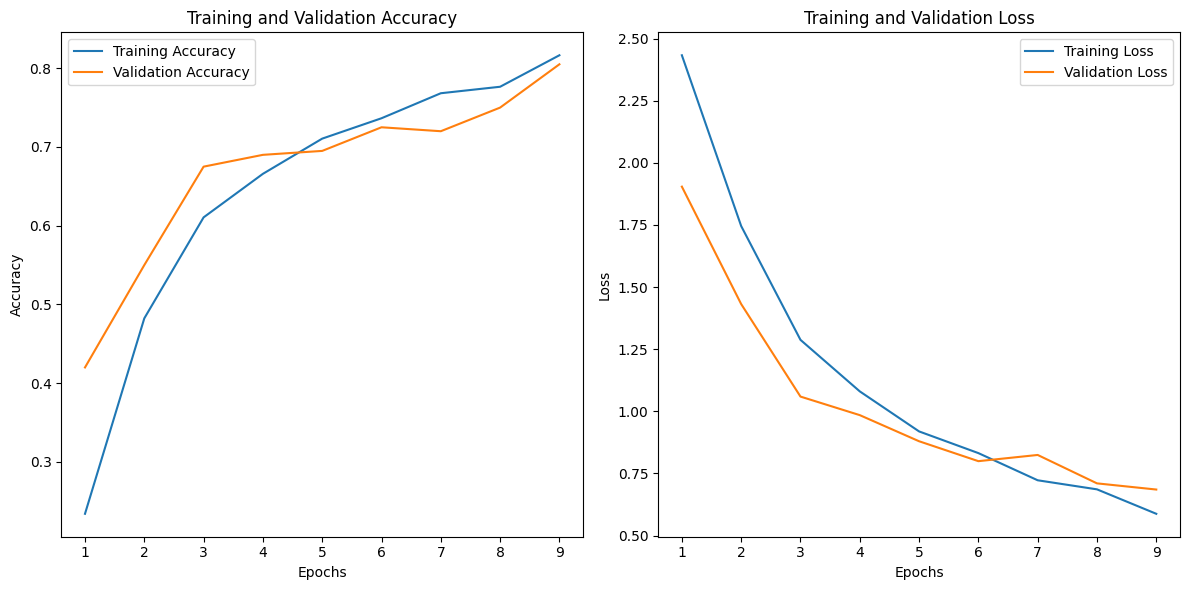

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
F1 Score: 0.6433

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.65      0.47        20
           1       0.65      0.55      0.59        20
           2       0.52      0.60      0.56        20
           3       0.48      0.65      0.55        20
           4       1.00      0.15      0.26        20
           5       0.78      0.70      0.74        20
           6       0.68      0.95     

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

test_dir = TEST_DIR

CLASSES = [
    "Batik Bali", "Batik Betawi", "Batik Cendrawasih", "Batik Dayak", "Batik Geblek Renteng",
    "Batik Ikat Celup", "Batik Insang", "Batik Kawung", "Batik Lasem", "Batik Megamendung",
    "Batik Pala", "Batik Parang", "Batik Poleng", "Batik Sekar Jagad", "Batik Tambal"
]
motives_dict = {cls: idx for idx, cls in enumerate(CLASSES)}

motives_list = list(motives_dict.keys())

for motive in motives_list:
    images_list = os.listdir(os.path.join(test_dir, motive))
    correct_count = 0

    print(f"\nEvaluating {motive}...")

    for idx, image in enumerate(images_list):
        img_path = os.path.join(test_dir, motive, image)

        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model(img_array, training=False)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

        print(f"Image: {image} | Predicted: {pred_motive} ({pred_confidence:.2f}%)")

    total_images = len(images_list)
    print(f"{motive} Predictions --> {correct_count}/{total_images} correct")


Evaluating Batik Bali...
Image: 78.jpg | Predicted: Batik Insang (47.67%)
Image: 77.jpg | Predicted: Batik Insang (29.16%)
Image: 79.jpg | Predicted: Batik Insang (36.39%)
Image: 80.jpg | Predicted: Batik Poleng (28.04%)
Image: 88.jpg | Predicted: Batik Insang (46.10%)
Image: 70.jpg | Predicted: Batik Insang (33.44%)
Image: 74.jpg | Predicted: Batik Insang (25.81%)
Image: 71.jpg | Predicted: Batik Insang (37.08%)
Image: 85.jpg | Predicted: Batik Insang (32.65%)
Image: 73.jpg | Predicted: Batik Insang (43.03%)
Image: 89.jpg | Predicted: Batik Insang (40.32%)
Image: 84.jpg | Predicted: Batik Insang (76.78%)
Image: 83.jpg | Predicted: Batik Insang (32.32%)
Image: 82.jpg | Predicted: Batik Insang (33.80%)
Image: 72.jpg | Predicted: Batik Insang (56.26%)
Image: 86.jpg | Predicted: Batik Insang (43.26%)
Image: 76.jpg | Predicted: Batik Insang (38.62%)
Image: 81.jpg | Predicted: Batik Insang (22.86%)
Image: 75.jpg | Predicted: Batik Insang (44.85%)
Image: 87.jpg | Predicted: Batik Insang (43

In [ ]:
import ipywidgets as widgets
from io import BytesIO

uploader = widgets.FileUpload(accept="image/*", multiple=False)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    try:
        image = tf.keras.utils.load_img(file, target_size=(224, 224))
        image = tf.keras.utils.img_to_array(image)
        image = (image / 127.5) - 1.0
        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image, verbose=0)[0]

        with out:
            out.clear_output()
            print(f'\nModel output: {prediction}')

            prediction_index = np.argmax(prediction)
            CLASSES = ["Batik Bali", "Batik Betawi", "Batik Cendrawasih", "Batik Dayak", "Batik Geblek Renteng", "Batik Ikat Celup", "Batik Insang", "Batik Kawung", "Batik Lasem", "Batik Megamendung", "Batik Pala", "Batik Parang", "Batik Poleng", "Batik Sekar Jagad", "Batik Tambal"]
            predicted_class = CLASSES[prediction_index]

            print(f'{filename} adalah {predicted_class}')
    except Exception as e:
        with out:
            out.clear_output()
            print(f"Error processing {filename}: {str(e)}")

def on_upload_change(change):
    for filename, fileinfo in change['new'].items():
        file_data = BytesIO(fileinfo['content'])
        file_predict(filename, file_data, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

Output()